# Variational Autoencoders (VAEs)

This notebook attempts to recreate examples of variational autoencoders from several blogs found online. Note: all comments made with '###' are my own, and the are from the code graciously borrowed from the tutorials.

## I. Jan Henrik Metzen's VAE

This VAE was written by Jan Hendrik Metzen and demonstrated at https://jmetzen.github.io/2015-11-27/vae.html.

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

In [3]:
# Load MNIST data in a format suited for tensorflow.
# The script input_data is available under this URL:
# https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/examples/tutorials/mnist/input_data.py
#import input_data
### alternate method of getting input_data borrowed from
### https://www.aiworkbox.com/lessons/load-the-mnist-data-set-in-tensorflow-so-that-it-is-in-one-hot-encoded-format
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

In [5]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        ### original tutorial used tf.mul; I've updated it to tf.multiply for tf 1.0+
        ### https://stackoverflow.com/questions/42217059/tensorflowattributeerror-module-object-has-no-attribute-mul
        self.z = tf.add(self.z_mean, 
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})

In [6]:
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

In [7]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space

vae = train(network_architecture, training_epochs=75)

Epoch: 0001 cost= 174.409492964
Epoch: 0006 cost= 108.612326535
Epoch: 0011 cost= 103.398732882
Epoch: 0016 cost= 101.249438546
Epoch: 0021 cost= 99.899721361
Epoch: 0026 cost= 98.936058419
Epoch: 0031 cost= 98.221917170
Epoch: 0036 cost= 97.531855372
Epoch: 0041 cost= 97.065502250
Epoch: 0046 cost= 96.609563723
Epoch: 0051 cost= 96.292099318
Epoch: 0056 cost= 95.879509763
Epoch: 0061 cost= 95.569231720
Epoch: 0066 cost= 95.296501659
Epoch: 0071 cost= 95.082017808


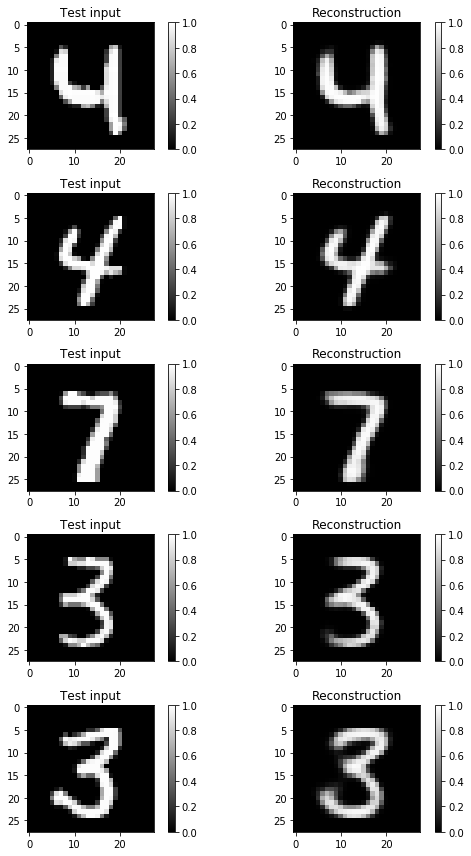

In [8]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

In [9]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

vae_2d = train(network_architecture, training_epochs=75)

/home/jcworkma/jack/3d-form/.3d-form/lib/python3.5/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0001 cost= 189.736929072
Epoch: 0006 cost= 152.839998863
Epoch: 0011 cost= 147.715709534
Epoch: 0016 cost= 145.249158797
Epoch: 0021 cost= 143.729257285
Epoch: 0026 cost= 142.591250805
Epoch: 0031 cost= 141.846152593
Epoch: 0036 cost= 141.186223727
Epoch: 0041 cost= 140.592657998
Epoch: 0046 cost= 140.204782645
Epoch: 0051 cost= 139.740775091
Epoch: 0056 cost= 139.469574973
Epoch: 0061 cost= 139.131085316
Epoch: 0066 cost= 138.910566087
Epoch: 0071 cost= 138.613886774


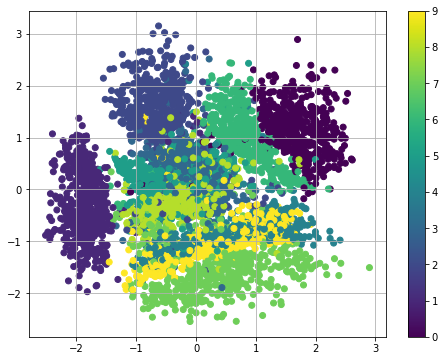

In [10]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()

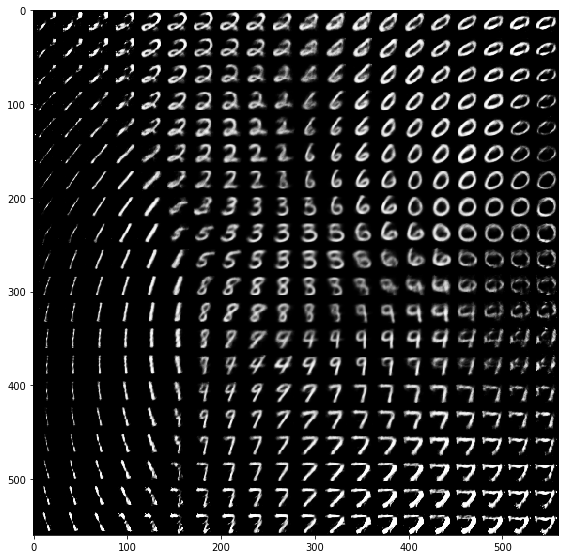

In [11]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

## II. Danijar Hafner's VAE

This VAE was written by Danijar Hafner and demonstrated at https://danijar.com/building-variational-auto-encoders-in-tensorflow/.

**NOTE**: doesn't quite work because of what I assume to be some incompatibility issues between tensorflow then and tensorflow now

In [91]:
### many numpy deprecation warnings...
np.warnings.filterwarnings('ignore')

In [92]:
import tensorflow as tf
tfd = tf.contrib.distributions

def make_encoder(data, code_size):
    x = tf.layers.flatten(data)
    x = tf.layers.dense(x, 200, tf.nn.relu)
    x = tf.layers.dense(x, 200, tf.nn.relu)
    loc = tf.layers.dense(x, code_size)
    scale = tf.layers.dense(x, code_size, tf.nn.softplus)
    return tfd.MultivariateNormalDiag(loc, scale)

In [93]:
def make_prior(code_size):
    loc = tf.zeros(code_size)
    scale = tf.ones(code_size)
    return tfd.MultivariateNormalDiag(loc, scale)

In [94]:
import numpy as np

def make_decoder(code, data_shape):
    x = code
    x = tf.layers.dense(x, 200, tf.nn.relu)
    x = tf.layers.dense(x, 200, tf.nn.relu)
    logit = tf.layers.dense(x, np.prod(data_shape))
    logit = tf.reshape(logit, [-1] + data_shape)
    return tfd.Independent(tfd.Bernoulli(logit), 2)

In [95]:
make_encoder = tf.make_template('encoder', make_encoder)
make_decoder = tf.make_template('decoder', make_decoder)

In [111]:
#data = tf.placeholder(tf.float32, [None, 28, 28])
### added quick reshape to account for the fact that mnist is delivered as one-hot vector
ph = tf.placeholder(tf.float32, [784,])
data = tf.reshape(ph, [28, 28])

prior = make_prior(code_size=2)
posterior = make_encoder(data, code_size=2)
code = posterior.sample()

likelihood = make_decoder(code, [28, 28]).log_prob(data)
divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)

In [112]:
optimize = tf.train.AdamOptimizer(0.001).minimize(-elbo)

In [113]:
samples = make_decoder(prior.sample(10), [28, 28]).mean()

In [114]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data/')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [108]:
mnist.train.next_batch(100)[0][0].shape

(784,)

In [109]:
#ph = tf.placeholder(tf.float32, [784,])
#rs = tf.reshape(ph, [28, 28])
#with tf.Session() as sess:
#    out = sess.run(rs, feed_dict={ph: mnist.train.next_batch(100)[0][0]})
#out.shape

In [115]:
with tf.train.MonitoredSession() as sess:
    for epoch in range(20):
        #test_elbo, test_codes, test_samples = sess.run(
        #    [elbo, code, samples], {data: mnist.test.images})
        #print('Epoch', epoch, 'elbo', test_elbo)
        #plot_codes(test_codes)
        #plot_sample(test_samples)
        for _ in range(600):
            for i in mnist.train.next_batch(100)[0]:
                sess.run(optimize, {ph: i})

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


FailedPreconditionError: Attempting to use uninitialized value beta2_power_8
	 [[node beta2_power_8/read (defined at <ipython-input-112-e2b9ba423a24>:1)  = Identity[T=DT_FLOAT, _class=["loc:@Adam_8/Assign_1"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](beta2_power_8)]]

Caused by op 'beta2_power_8/read', defined at:
  File "C:\Program Files\Python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Program Files\Python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Program Files\Python36\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "C:\Program Files\Python36\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "C:\Program Files\Python36\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-112-e2b9ba423a24>", line 1, in <module>
    optimize = tf.train.AdamOptimizer(0.001).minimize(-elbo)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tensorflow\python\training\optimizer.py", line 410, in minimize
    name=name)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tensorflow\python\training\optimizer.py", line 593, in apply_gradients
    self._create_slots(var_list)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tensorflow\python\training\adam.py", line 131, in _create_slots
    colocate_with=first_var)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tensorflow\python\training\optimizer.py", line 814, in _create_non_slot_variable
    v = variable_scope.variable(initial_value, name=name, trainable=False)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tensorflow\python\ops\variables.py", line 183, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tensorflow\python\ops\variables.py", line 146, in _variable_v1_call
    aggregation=aggregation)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tensorflow\python\ops\variables.py", line 125, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2444, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tensorflow\python\ops\variables.py", line 187, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tensorflow\python\ops\variables.py", line 1329, in __init__
    constraint=constraint)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tensorflow\python\ops\variables.py", line 1491, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tensorflow\python\ops\array_ops.py", line 81, in identity
    return gen_array_ops.identity(input, name=name)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 4103, in identity
    "Identity", input=input, name=name)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W210\3d-form\.3d-form\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value beta2_power_8
	 [[node beta2_power_8/read (defined at <ipython-input-112-e2b9ba423a24>:1)  = Identity[T=DT_FLOAT, _class=["loc:@Adam_8/Assign_1"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](beta2_power_8)]]
